# Hypothesis Testing

Lukas Graz  
February 13, 2025

In [ ]:
source("R/data_prep.R")


Number of matches per filter criteria (not disjoint)
  Headphone  PRS_all_NA    Distance Activity_NA    Duration  HMNoise_NA 
        303         226         221         102          96          96 
JourneyTime 
         20 
Keep  1494 of 2206 observations

Imputing PRS_orig_vars

## Linear Modeling

### Imputation with MissForest on Training Data

In [ ]:
sapply(D[Mediator_vars], \(x) sum(is.na(x)))


 FEELNAT   LNOISE LOC_SENS LOC_SOUN LOC_SCEN LOC_VISE LOC_VEGE LOC_FAUN 
      16      291       28       30       36       62       69       88 

  LCARTIF_sqrt  LCFOREST_sqrt          HETER    OVDIST_sqrt     VIS5K_sqrt 
             0              0              0              0              0 
       RL_NDVI       RL_NOISE    DISTKM_sqrt   JNYTIME_sqrt STRIMP123_sqrt 
             0              0              0             86              0 
STRIMP999_sqrt 
             0 

In [ ]:
# Mediator imputation
D_trn[Mediator_vars] <- xfun::cache_rds({
  missForest(as.matrix(D_trn[Mediator_vars]))
  }, 
  file = "Mediator_imputation.rds", 
  dir = "cache/",
  hash = list(as.matrix(D_trn[Mediator_vars]))
)$ximp |> as.data.frame()

# GIS imputation (missForest)
D_trn[GIS_vars] <- xfun::cache_rds({
  missForest(as.matrix(D_trn[GIS_vars]))
  }, 
  file = "GIS_imputation.rds", 
  dir = "cache/",
  hash = list(as.matrix(D_trn[GIS_vars]))
)$ximp |> as.data.frame()


### Remove “LOC\_” variables from Mediators

### Scaling Test Data

In [ ]:
all_vars <- c(Mediator_vars, GIS_vars, PRS_vars)
old_scale <- t(sapply(D_tst[c(all_vars)], \(x) 
  c(mean = mean(x, na.rm = TRUE), sd = sd(x, na.rm = TRUE))))

D_tst[c(all_vars)] <- lapply(D_tst[c(all_vars)], scale)
D_trn_scaled <- D_trn
D_trn_scaled[c(all_vars)] <- lapply(D_trn[c(all_vars)], scale)

old_scale


                 mean     sd
FEELNAT         6.142  1.055
LNOISE          4.210  0.747
LOC_SENS        4.098  1.016
LOC_SOUN        4.296  0.947
LOC_SCEN        3.967  1.056
LOC_VISE        4.080  1.027
LOC_VEGE        4.343  0.859
LOC_FAUN        3.298  1.365
LCARTIF_sqrt    0.271  0.269
LCFOREST_sqrt   0.454  0.311
HETER           1.305  0.402
OVDIST_sqrt    21.797 10.144
VIS5K_sqrt      3.323  1.620
RL_NDVI         0.635  0.202
RL_NOISE       41.615  9.261
DISTKM_sqrt     1.473  1.156
JNYTIME_sqrt    3.830  2.247
STRIMP123_sqrt  6.555 10.739
STRIMP999_sqrt 47.557 13.162
MEAN            4.987  0.881
FA              5.266  1.111
BA              5.140  1.157
EC              4.539  1.288
ES              5.010  1.429

### Testing VIF

In [ ]:
car::vif(fit_PRS_MED <- lm(as.formula(paste0(
  PRS_vars[1], 
  " ~ ", 
  paste(Mediator_vars, collapse = " + "), " + ",
  paste(GIS_vars,      collapse = " + ")
)), D_trn)) |> summary()


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.21    1.46    1.94    2.03    2.24    4.99 

In [ ]:
suppressMessages(
car::vif(fit_PRS_MED <- lm(as.formula(paste0(
  PRS_vars[1], 
  " ~ ", 
  "(", paste(Mediator_vars, collapse = " + "), 
     " + ", paste(GIS_vars, collapse = " + "), 
  ")^2"
)), D_trn))) |> summary()


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   11.9    81.4   147.6   204.9   270.7  1391.7 

Since we model *with* interactions later, the latter VIF are relevant for us. Given that they are very high (c.f. median and max), we would have no hope of finding any significant results in the full interaction model. Therefore, we will first perfom a variable selection, to reduce the VIF and enable us to find significant effects.

### All Interactions: Mediators ~ (GIS)^2

In [ ]:

# Elegant function to create coefficient tables from model summaries
suppressPackageStartupMessages({
library(dplyr)
library(tidyr)
library(knitr)
library(purrr)
})
#' Create a formatted coefficient table from model summary list
#' 
#' @param model_summaries List of model summaries (e.g., output from lapply(models, summary))
#' @param sig_threshold Significance threshold for bold formatting (default: 0.001)
#' @param covariate_order Optional vector specifying order of covariates
#' @return Formatted table with models as columns and covariates as rows
create_coef_table <- function(model_summaries, sig_threshold = 0.001, covariate_order = NULL) {
  
  # Extract and format coefficients for all models
  format_model_coef <- function(coef_matrix, model_name) {
    estimates <- coef_matrix[, "Estimate"]
    p_values <- coef_matrix[, "Pr(>|t|)"]
    
    # Format with significance stars (common notation)
    formatted_coef <- sapply(seq_along(estimates), function(i) {
      est_str <- sprintf("%.3f", estimates[i])
      stars <- case_when(
        p_values[i] < 0.001 ~ "***",
        p_values[i] < 0.01 ~ "**",
        p_values[i] < 0.05 ~ "*",
        p_values[i] < 0.1 ~ ".",
        TRUE ~ ""
      )
      paste0(est_str, stars)
    })
    
    tibble(
      Model = model_name,
      Covariate = rownames(coef_matrix),
      Coefficient = formatted_coef
    )
  }
  
  # Process all models and create wide table
  coef_list <- map(model_summaries, coef)
  
  results_table <- map2_dfr(coef_list, names(coef_list), format_model_coef) %>%
    pivot_wider(names_from = Model, values_from = Coefficient, values_fill = "")
  
  # Apply covariate ordering
  if (is.null(covariate_order)) {
    # Default: Intercept first, then alphabetical
    all_covariates <- unique(results_table$Covariate)
    covariate_order <- c("(Intercept)", sort(all_covariates[all_covariates != "(Intercept)"]))
  }
  
  # Filter and reorder covariates
  results_table <- results_table %>%
    filter(Covariate %in% covariate_order) %>%
    slice(match(covariate_order, Covariate))
  
  kable(results_table, 
        format = "pipe",
        align = c("l", rep("c", ncol(results_table) - 1)))
}


In [ ]:
Res3 <- list()
for (mediator in Mediator_vars) {
  intercept_model <- lm(as.formula(paste0(
    mediator, " ~ 1")), D_trn)
  step_model <- step(intercept_model, 
    scope = as.formula(paste0(
      mediator, " ~ ", 
      "(", paste(GIS_vars, collapse = " + "), ")^2"
    )),
    trace = FALSE, k = log(nrow(D_trn))
  )
  Res3[[mediator]] <- lm(formula(step_model), D_tst)
}
(ResSum3 <- lapply(Res3, summary))


$FEELNAT

Call:
lm(formula = formula(step_model), data = D_tst)

Residuals:
   Min     1Q Median     3Q    Max 
-4.959 -0.391  0.264  0.607  1.685 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.0618     0.0410    1.51  0.13260    
LCARTIF_sqrt          -0.1524     0.0570   -2.67  0.00770 ** 
RL_NDVI                0.1498     0.0436    3.43  0.00063 ***
OVDIST_sqrt            0.0270     0.0452    0.60  0.55112    
LCARTIF_sqrt:RL_NDVI   0.1146     0.0402    2.85  0.00446 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.948 on 733 degrees of freedom
  (9 observations deleted due to missingness)
Multiple R-squared:  0.106, Adjusted R-squared:  0.101 
F-statistic: 21.8 on 4 and 733 DF,  p-value: <2e-16


$LNOISE

Call:
lm(formula = formula(step_model), data = D_tst)

Residuals:
   Min     1Q Median     3Q    Max 
-3.999 -0.527  0.012  0.676  1.622 

Coefficients:
             Estimate 

#### Visualization of Interactioneffect of LCARTIF_sqrt \* RL_NDVI

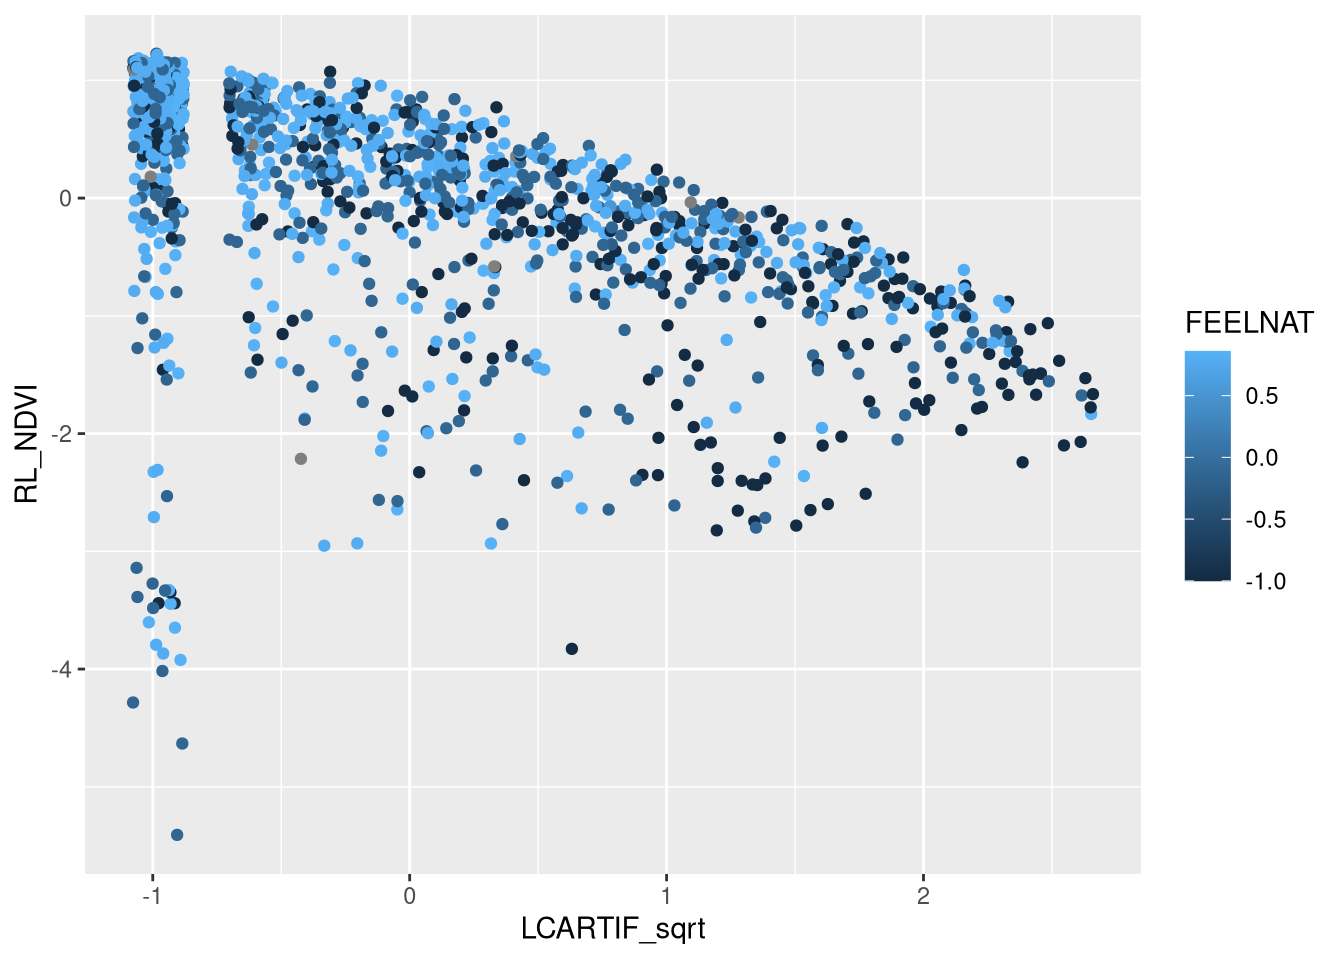

Warning in geom_point(width = 0.07, alpha = 0.6): Ignoring unknown parameters:
`width`

`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

(`geom_point()`).

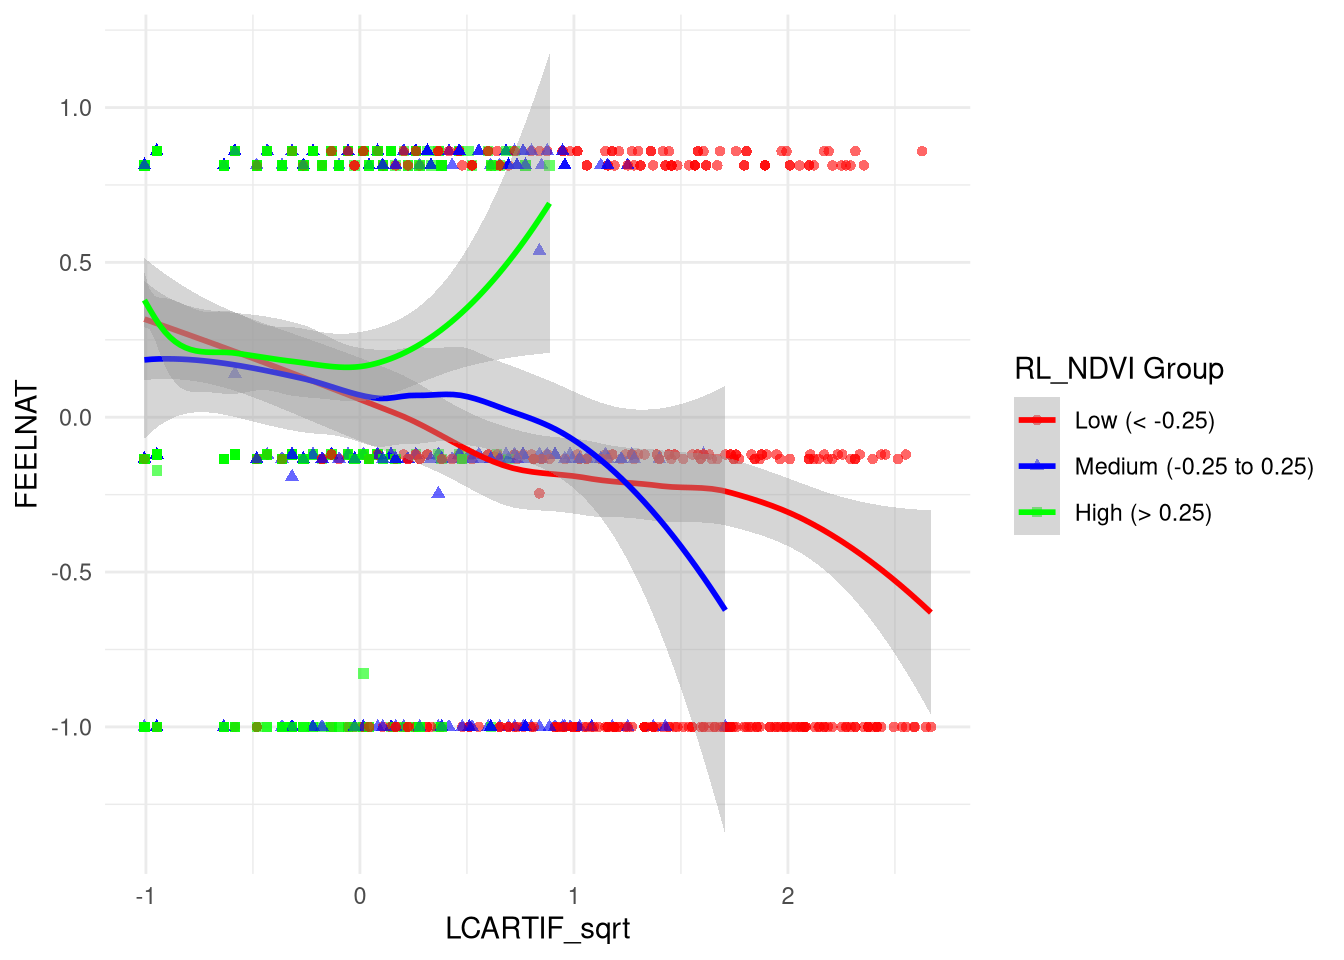

In [ ]:

library(ggplot2)
D_plot <- rbind(D_trn_scaled, D_tst)
D_plot$FEELNAT <- pmax(-1,pmin(1,D_plot$FEELNAT))
ggplot(D_plot, aes(x = LCARTIF_sqrt, y=RL_NDVI, col = FEELNAT)) +
  geom_jitter(width=0.07)


### All Interactions: PRS ~ (Mediators + GIS)^2

In [ ]:
Res4 <- list()
for (prs in PRS_vars) {
  intercept_model <- lm(as.formula(paste0(
    prs, " ~ 1")), D_trn)
  step_model <- step(intercept_model, 
    scope = as.formula(paste0(
      prs, " ~ ", 
      "(", paste(GIS_vars, collapse = " + "), " + ", 
      paste(Mediator_vars, collapse = " + "), ")^2"
    )),
    trace = FALSE, k = log(nrow(D_trn))
  )
  Res4[[prs]] <- lm(formula(step_model), D_tst)
}
(ResSum4 <- lapply(Res4, summary))


$MEAN

Call:
lm(formula = formula(step_model), data = D_tst)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7964 -0.5913 -0.0025  0.5989  2.8496 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.00280    0.03815   -0.07  0.94161    
LOC_VISE          0.16024    0.04451    3.60  0.00035 ***
FEELNAT           0.20288    0.04553    4.46  1.0e-05 ***
LOC_SENS          0.09165    0.04433    2.07  0.03914 *  
LNOISE            0.17030    0.04197    4.06  5.7e-05 ***
DISTKM_sqrt      -0.00209    0.03973   -0.05  0.95813    
LCARTIF_sqrt      0.02074    0.04139    0.50  0.61648    
LOC_SCEN          0.04437    0.04607    0.96  0.33597    
FEELNAT:LOC_SENS  0.05405    0.02950    1.83  0.06751 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.896 on 560 degrees of freedom
  (178 observations deleted due to missingness)
Multiple R-squared:  0.191, Adjusted R-squared:  0.179 
F-statistic: 16.5 on 

### Table Summarizing Coefficients

Significant codes as usual: `0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1`

#### All Interactions: Mediators ~ (GIS)^2

In [ ]:
ResTab3 <- create_coef_table(ResSum3)
saveRDS(ResTab3, "cache/ResSum3.rds")
ResTab3


  --------------------------------------------------------------------------------------------------------------------------------------
  Covariate                 FEELNAT        LNOISE       LOC_SENS       LOC_SOUN      LOC_SCEN     LOC_VISE    LOC_VEGE       LOC_FAUN
  ---------------------- ------------- -------------- ------------- -------------- ------------- ---------- ------------- --------------
  (Intercept)                0.062         -0.001        -0.000         0.000         -0.001       -0.000      -0.019         -0.001

  HETER                                                0.130\*\*\*    0.109\*\*                                           

  JNYTIME_sqrt                                                                                               -0.114\*\*   

  LCARTIF_sqrt            -0.152\*\*      -0.124\*                   -0.175\*\*\*                 -0.071.                  -0.214\*\*\*

  LCARTIF_sqrt:RL_NDVI     0.115\*\*                                                                                      

  OVDIST_sqrt                0.027                                                                                        

  RL_NDVI                 0.150\*\*\*                                               0.217\*\*\*              0.219\*\*\*  

  RL_NOISE                              -0.242\*\*\*                                                                      

  STRIMP999_sqrt                                         -0.073.                                                          
  --------------------------------------------------------------------------------------------------------------------------------------


#### PRS ~ (Mediators + GIS)^2

In [ ]:
ResTab4 <- create_coef_table(ResSum4)
saveRDS(ResTab4, "cache/ResSum4.rds")
ResTab4


  -----------------------------------------------------------------------------------------
  Covariate              MEAN            FA            BA            EC            ES
  ------------------ ------------- -------------- ------------- ------------- -------------
  (Intercept)           -0.003         -0.002        -0.007        -0.008         0.030

  DISTKM_sqrt           -0.002                                                   0.080\*

  FEELNAT             0.203\*\*\*   0.169\*\*\*    0.188\*\*\*                 0.259\*\*\*

  FEELNAT:LOC_SCEN                     -0.002                                 

  FEELNAT:LOC_SENS      0.054.                                                

  LCARTIF_sqrt           0.021                                                

  LCFOREST_sqrt                                                   -0.089\*    

  LNOISE              0.170\*\*\*   0.133\*\*\*                                 0.133\*\*

  LNOISE:FEELNAT                                                                 -0.006

  LOC_FAUN                          0.176\*\*\*                               

  LOC_SCEN               0.044      0.164\*\*\*                    -0.002     

  LOC_SENS              0.092\*                    0.147\*\*\*   0.143\*\*\*     0.095\*

  LOC_VISE            0.160\*\*\*    0.128\*\*      0.121\*\*                 

  RL_NDVI                           -0.133\*\*\*                              

  RL_NDVI:LOC_SCEN                     0.024                                  
  -----------------------------------------------------------------------------------------
